# Part 1: Tabular Q-Learning

In this part of the assignment you will familiarize yourself with the [Gymnasium API](https://gymnasium.farama.org/) for reinforcement learning and implement a tabular Q-learning agent to learn a behavioral policy in the simple [Taxi environment](https://gymnasium.farama.org/environments/toy_text/taxi/). This is intended as a warmup on a relatively small and simple task, preparing for a more challenging deep reinforcement learning task in part 2.

**Learning objectives.** You will:
1. Install and study the standard Gymnasium API for representing a reinforcement learning environment simulation
2. Implement the tabular Q-learning algorithm with epsilon greedy action selection
3. Train an agent / compute an optimal q function and policy, experimenting with various hyperparameters like the learning rate and exploration decay
4. Evaluate the learning curve of average episodic return over training

We will use the [Gymnasium API](https://gymnasium.farama.org/) for our reinforcement learning environments. First you should run one of the following to install the necessary packages (either using `pip` or `conda` depending on your preferred Python package manager).

In [28]:
pip install "gymnasium[all]"

Defaulting to user installation because normal site-packages is not writeable
  Using cached gymnasium-1.0.0-py3-none-any.whl (958 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install -c conda-forge gymnasium-all

If you have trouble with the above installation, try the simpler `pip install gymnasium` or `conda install -c conda-forge gymnasium` command (which does not install all of the dependencies that may only be needed for specific environments). 

You can check that the installation was successful by running the following code. The code attempts to import the gymnasium module, create a simple [Taxi environment](https://gymnasium.farama.org/environments/toy_text/taxi/), and then execute random actions in the environment. 

The environment is set to `render_mode="human"`, meaning you should see a visualization of the environment with the agent taking random actions. Be aware that the visualization can be unstable on some platforms -- in particular, if your Python Kernel crashes after closing the visualization, that will not prevent you from completing the assignment (but is a good indication that you should save your learned Q tables/networks before rendering a visualization so that you don't lose any work).

In [1]:
import gymnasium as gym

# Initialise the environment
env = gym.make("Taxi-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset()
for _ in range(100):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

error: XDG_RUNTIME_DIR not set in the environment.


Next you should review the [Gymnasium Basic Usage Documentation](https://gymnasium.farama.org/introduction/basic_usage/) (through the Action and observation spaces section; you do not need to worry about the section on Modifying the environment). It may also be helpful to review or refer to the [Environment API documentation here](https://gymnasium.farama.org/api/env/).

## Task 1

Your first task is to define a **tabular** Q-learning agent for the simple [Taxi Environment](https://gymnasium.farama.org/environments/toy_text/taxi/). You should refer to the environment documentation to understand the state/observation space, action space, and reward function.

Your agent `class` should implement at least the following three methods:
1. The constructor, `__init__()`, should should store any relevant hyperparameters as instance variables and initialize a Q table, along with any other auxiliary instance variables you may choose to include.
2. The `action_select` method which should implement `epsilon` greedy action selection (`epsilon` should be an instance variable kept track of by the agent object).
3. The `update` method should take an environment experience (previous state, action taken, reward received, new state, and whether the episode terminated) as input and should perform a Q learning update on the Q table.

 You are welcome but not required to add additional helper methods.

In [2]:
from collections import defaultdict
import numpy as np
class TaxiAgent:
    """
    Implements a tabular q learning agent for the taxi 
    environment with discrete states and actions.
    """
    def __init__(self, env, lr=0.01, discount=0.99,
                 epsilon_init=1.0, epsilon_final=0.05,
                 epsilon_decay=0.99):
        self.epsilon=epsilon_init
        self.epsilon_decay=epsilon_decay
        self.epsilon_final=epsilon_final
        self.lr=lr
        self.discount=discount
        self.env=env
        self.q=defaultdict(lambda: [0]*env.action_space.n)



    def action_select(self, s):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q[s])


    def update(self, s_old, a, r, s_new, terminated):
        target=r
        if not terminated:
            target+=self.discount*np.max(self.q[s_new])
        error=target-self.q[s_old][a]
        self.q[s_old][a] +=error*self.lr
        self.epsilon = max(self.epsilon_final, self.epsilon * self.epsilon_decay)

## Task 2

Now that you have defined your learning agent, implement a training loop over several episodes of experience with the environment. Your goal is to learn an optimal q function and corresponding policy (in the Taxi environment, that just implies efficiently picking up and delivering passengers to their appropriate destimations). 

Practically speaking, you should be able to learn a policy that achieves an average/expected episode return (cumulative reward) of approximately 0 (because the agent receives 20 reward for a correct dropoff, and -1 for each timestep, and it will require 10-20 timesteps on average to complete a pickup and dropoff). To accomplish this you may need to experiment with several of the key hyperparameters for the learning agent.

While you are not required, you are encouraged to print periodic evaluation information during training (for example, every 100 or so episodes you may wish to printout the average return of the last 100 episodes) in order to track progress.

Training should be quick on this environment: You should be able to learn an essentially optimal policy within several hundred or a few thousand episodes requiring only a few seconds of time.

In [8]:
# Initialise the environment
import gymnasium as gym
import torch
# todo: adjust n_episodes as needed for training
# default value of 100 for prototyping, will likely
# want more episodes for training
n_episodes = 1000
gpu=torch.device("cuda")
env = gym.make("Taxi-v3")

# wrapper saves episode information necessary for later evaluation in task 3
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length = n_episodes)

# todo: environment loop with Q learning
agent=TaxiAgent(env)
for episode in range(n_episodes):
    state, info=env.reset()
    episode_over=False
    while not episode_over:
        a=agent.action_select(state)
        s_new, r, term, trunc, info = env.step(a)
        episode_over = term or trunc
        agent.update(state,a,r,s_new,term)
        state=s_new
env.close()

## Task 3

After training, you can use the `visualize_learning_curves` function below to create two plots: One of the moving average episode return over the course of training and another of the moving average episode length over the course of training. A `smoothing` parameter to the function determines how many episodes to average over. That is, the default of `smoothing=10` means that each point in the resulting figure is the average of ten episodes. This has the visual effect of *smoothing* out the appearance of the plot, which can make the overall trend easier to visualize even if individual episodes vary significantly.

Create visualizations of your learning curves. You should see improving performance on average episode return converging toward approximately zero.

In [11]:
# Run, but you do not need to modify this code

import numpy as np
from matplotlib import pyplot as plt

def visualize_learning_curves(env, smoothing=10):
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(np.convolve(env.return_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[0].set_title("Episode Returns", fontsize=20)
    axs[0].set_xlabel("Episode", fontsize=20)
    axs[0].set_ylabel("Return", fontsize=20)

    axs[1].plot(np.convolve(env.length_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[1].set_title("Episode Lengths", fontsize=20)
    axs[1].set_xlabel("Episode", fontsize=20)
    axs[1].set_ylabel("Length", fontsize=20)

    plt.tight_layout()
    plt.show()

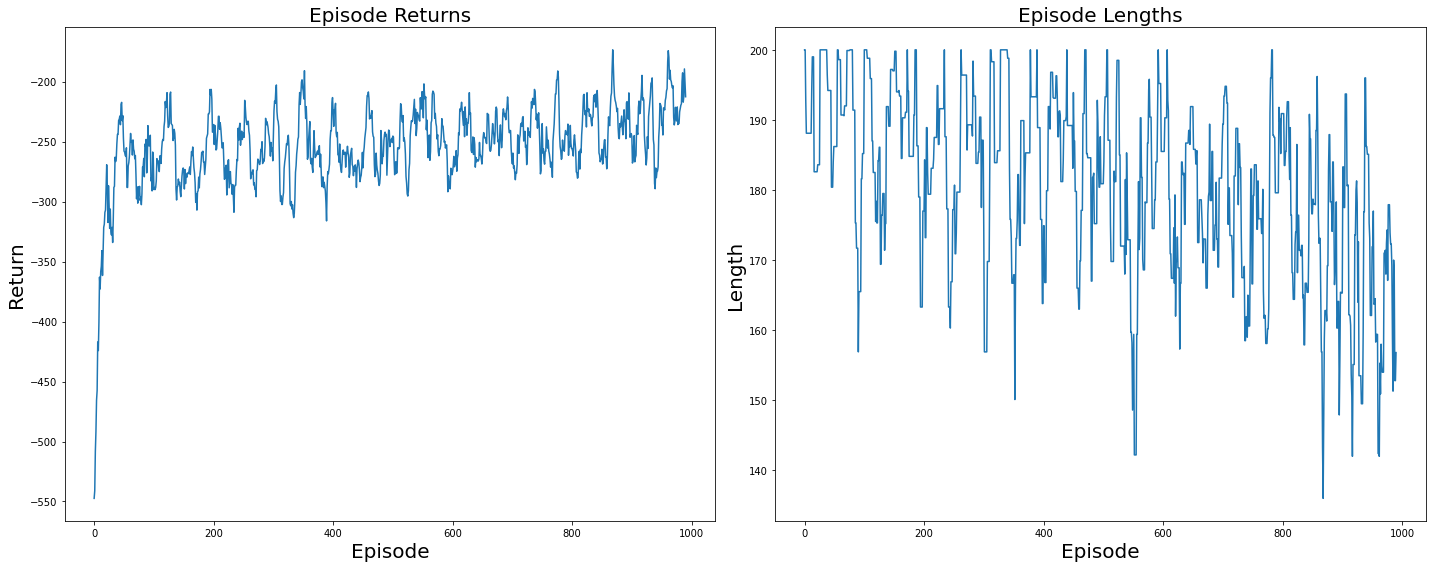

In [12]:
visualize_learning_curves(env)

## Optional

The above evaluation of the learning curve was purely quantiative. While you are not required, you are invited and encouraged to qualitatively evaluate your learned policy/agent visually below. To do so, render the environment in `"human"` mode as shown below. This should render the visualization of the environment. Write a standard environment loop over several episodes (but far fewer than used for training, perhaps just 5 or so), and use the trained agent for action selection. For this evaluation purpose, you are welcome to set `epsilon` to a lower value or even 0, and you do not need to perform learning updates.

Again, be aware that the visualization can be unstable on some platforms -- in particular, if your Python Kernel crashes after closing the visualization, that will not prevent you from completing the assignment (but is a good indication that you should save your learned Q tables/networks before rendering a visualization so that you don't lose any work).

In [ ]:
# Initialise the environment
env = gym.make("Taxi-v3", render_mode="human")

# optional todo: environment loop to visualize learned policy